# utils & framework

In [ ]:
from typing import List, Any
from collections.abc import Iterable

import scipy.constants
from IPython.core.display import Markdown
from sympy import *
from sympy.vector import *

tag_id = 0
conditions = {}
values = {}
formulas_names = {}
restore_stack = []


def reset():
    global tag_id, conditions, values, formulas_names
    if restore_stack:
        state = restore_stack[-1]
        tag_id = state['tag_id']
        conditions = state['conditions'].copy()
        values = state['values'].copy()
        formulas_names = state['formulas_names'].copy()


def push_state():
    global restore_stack
    restore_stack.append({
        'tag_id': tag_id,
        'conditions': conditions.copy(),
        'values': values.copy(),
        'formulas_names': formulas_names.copy()
    })


def pop_state():
    global restore_stack
    return restore_stack.pop()


def save_as_condition(condition):
    global tag_id, conditions
    cached_condition_id = tag_id
    condition = spf(condition)
    conditions[tag_id] = condition
    tag_id += 1
    return cached_condition_id


def substitute_values(expression, mask=None):
    while True:
        left = False
        items = values.items() if mask is None else filter(lambda item: item[0] in mask, values.items())
        for (key, value) in items:
            before = str(expression)
            expression = expression.subs(key, value)
            expression = simplify(expression)
            if str(expression) != before:
                left = True
        if not left:
            break

    return expression


def save_as_variable(symbol, value):
    global values
    if symbol in values.keys():
        raise ValueError(f"variable {symbol} already exists")
    values[symbol] = substitute_values(S(value))


def save_as_formula_name(symbol, formula):
    global tag_id, formulas_names
    tag_id += 1
    if symbol in formulas_names.keys():
        raise ValueError(f"formula {symbol} already exists")
    formulas_names[symbol] = formula


def beautiful_print(expression, message="", tag=None):
    expression = expression if isinstance(expression, str) else latex(expression)
    inline = not message.endswith('$')
    tag_str = f'\\tag{{{tag}}}' if tag is not None else ""
    if inline:
        full_latex = message + '$' + expression + '$'
    else:
        full_latex = message + '$' + expression + tag_str + '$$'
    display(Markdown(full_latex))


def beautiful_answer(expression, message="$", f: bool = False):
    symbol = expression
    expression = spf(expression)
    expression = expression.evalf() if f else expression
    beautiful_print(Eq(symbol, expression, evaluate=false), message, tag="answer")


def beautiful_peek(symbol, message="$", tag=None):
    value = substitute_values(symbol)
    beautiful_print(Eq(symbol, value, evaluate=False), message, tag)


def beautiful_solve(cond, variables, apply: dict = None):
    cond = [cond] if not isinstance(cond, Iterable) else cond
    display(Markdown(f"${','.join(f"\\left ( {i} \\right ) " for i in cond)} \\Longrightarrow$"))

    variables = [variables] if not isinstance(variables, Iterable) else variables

    apply = apply if apply is not None else {}

    cond = tuple(map(lambda i: conditions[i].subs(apply), cond))
    cond = map(lambda i: substitute_values(i), cond)
    solution = solve(cond, tuple(variables), dict=True)[0]
    conclusions = []
    for (variable, conclusion) in solution.items():
        beautiful_print(Eq(variable, conclusion), "$")
        save_as_variable(variable, conclusion)
        conclusions.append(conclusion)


def beautiful_condition(expression, message="$"):
    beautiful_print(expression(False) if callable(expression) else expression, message, tag_id)
    return save_as_condition(expression(True) if callable(expression) else expression)


def beautiful_compute(symbol, expression, message="$", tag=None):
    symbol = symbols(symbol) if isinstance(symbol, str) else symbol
    global tag_id
    beautiful_print(Eq(symbol, expression(False) if callable(expression) else expression, evaluate=False), message,
                    tag_id if tag else None)
    if tag:
        tag_id += 1
    save_as_variable(symbol, expression(True) if callable(expression) else expression)
    return symbol


def beautiful_formula(symbol: str, expression: object, message: object = "$", ) -> Any:
    beautiful_print(f"{symbol}=" + latex(expression), message, tag_id)
    save_as_formula_name(expression, symbol)
    return expression


def beautiful_at(formula, subs: dict, message="$", tag: bool = None):
    result = simplify(formula.subs(subs))
    param = '\\,'.join(f"{latex(item[0])}={latex(item[1])}" for item in subs.items())
    beautiful_print(formulas_names[formula] + f"\\bigg|_{{{param}}}=" + latex(result), message, tag)
    return result


def spf(expression):
    expression = substitute_values(expression)
    expression = simplify(expression)
    return expression


class D:
    def __init__(self, symbol: Symbol, name: str = None):
        symbol = 'd' + latex(symbol) if name is None else name
        self.symbol = Symbol(symbol)

    def __enter__(self):
        return self.symbol

    def __exit__(self, type, value, traceback):
        save_as_variable(self.symbol, 1)


def map_vector(vec, func):
    return sum(
        # 0 is i/j/k sharp, 1 is expr
        map(lambda item: func(item[1]) * item[0], vec.components.items()),
        Vector.zero
    )


def series_vector(vec, param, x0=0, n=2):
    return map_vector(vec, lambda e: series(e, param, x0, n).removeO())


def integrate_vector(vec, param):
    return map_vector(vec, lambda e: integrate(e, param))


def beautiful_vector(xi=0, yj=0, zk=0):
    xi = Symbol(xi) if isinstance(xi, str) else xi
    yj = Symbol(yj) if isinstance(yj, str) else yj
    zk = Symbol(zk) if isinstance(zk, str) else zk
    return xi * coord.i + yj * coord.j + zk * coord.k


coord = CoordSys3D('')


def refine_piecewise(pw_expr, assume):
    """Refine a Piecewise expression with given assumptions."""
    if not isinstance(pw_expr, Piecewise):
        return refine(pw_expr, assume)

    for expr_val, cond in pw_expr.args:
        if cond:  # Default/otherwise branch
            return refine(expr_val, assume)
        elif ask(cond, assume):
            return refine(expr_val, assume)

    # If no branch can be definitively chosen, refine each branch
    refined_args = [(refine(expr_val, assume), cond)
                    for expr_val, cond in pw_expr.args]
    return Piecewise(*refined_args)


## Common

In [ ]:
epsilon = symbols('epsilon_0', positive=True)
k = 1 / (4 * pi * epsilon)
charge = symbols('q')
x = coord.x
y = coord.y
z = coord.z
pos = x * coord.i + y * coord.j + z * coord.k
E = beautiful_formula('E', k * charge * pos / pos.magnitude() ** 3, "by Coulomb's law:$")
electric_flux = Symbol('phi_e')
enclosed_charge_sum = Symbol('Q_{sum}')
Gauss_law = beautiful_condition(Eq(electric_flux, enclosed_charge_sum / epsilon), "by Gauss's law:$")


def fn_potential(q, r):
    return k * q / r


P = beautiful_formula('\\varphi', fn_potential(charge, pos.magnitude()), 'electric potential:$')


def save_common_consts():
    save_as_variable(epsilon, scipy.constants.epsilon_0)
    save_as_variable(pi, scipy.constants.pi)


push_state()

# 3.6

In [104]:
def t36():
    reset()
    t = Symbol('t')
    phi = Function('phi')(t)
    r = Function('r')(t)
    x = beautiful_compute(Function('x')(t), r * cos(phi), "axis in pole:$")
    y = beautiful_compute(Function('y')(t), r * sin(phi), "axis in pole:$")

    c1 = beautiful_condition(Eq(diff(x, t, 2), 0), "by const speed:$")
    c1 = beautiful_condition(Eq(diff(substitute_values(x), t, 2), 0), "that is :$")
    c2 = beautiful_condition(Eq(diff(y, t, 2), 0), "by const speed:$")
    c2 = beautiful_condition(Eq(diff(substitute_values(y), t, 2), 0), "that is :$")

    dd_phi = diff(phi, t, 2)
    dd_r = diff(r, t, 2)
    beautiful_solve([c1, c2], [dd_phi, dd_r])


t36()

axis in pole:$$x{\left(t \right)} = r{\left(t \right)} \cos{\left(\phi{\left(t \right)} \right)}$$

axis in pole:$$y{\left(t \right)} = r{\left(t \right)} \sin{\left(\phi{\left(t \right)} \right)}$$

by const speed:$$\frac{d^{2}}{d t^{2}} x{\left(t \right)} = 0\tag{3}$$

that is :$$- \left(\sin{\left(\phi{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \phi{\left(t \right)} + \cos{\left(\phi{\left(t \right)} \right)} \left(\frac{d}{d t} \phi{\left(t \right)}\right)^{2}\right) r{\left(t \right)} - 2 \sin{\left(\phi{\left(t \right)} \right)} \frac{d}{d t} \phi{\left(t \right)} \frac{d}{d t} r{\left(t \right)} + \cos{\left(\phi{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} r{\left(t \right)} = 0\tag{4}$$

by const speed:$$\frac{d^{2}}{d t^{2}} y{\left(t \right)} = 0\tag{5}$$

that is :$$- \left(\sin{\left(\phi{\left(t \right)} \right)} \left(\frac{d}{d t} \phi{\left(t \right)}\right)^{2} - \cos{\left(\phi{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \phi{\left(t \right)}\right) r{\left(t \right)} + \sin{\left(\phi{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} r{\left(t \right)} + 2 \cos{\left(\phi{\left(t \right)} \right)} \frac{d}{d t} \phi{\left(t \right)} \frac{d}{d t} r{\left(t \right)} = 0\tag{6}$$

$\left ( 4 \right ) ,\left ( 6 \right )  \Longrightarrow$

$$\frac{d^{2}}{d t^{2}} \phi{\left(t \right)} = - \frac{2 \frac{d}{d t} \phi{\left(t \right)} \frac{d}{d t} r{\left(t \right)}}{r{\left(t \right)}}$$

$$\frac{d^{2}}{d t^{2}} r{\left(t \right)} = r{\left(t \right)} \left(\frac{d}{d t} \phi{\left(t \right)}\right)^{2}$$

# 3.7

In [105]:
def t37():
    reset()
    t = Symbol('t')
    phi = Function('phi')(t)
    x = Function('x')(t)
    y = Function('y')(t)
    l = Symbol('l')
    V0 = Symbol('V0')
    rho = beautiful_compute(Function('rho')(t), l - V0 * t, "by geometry:$")

    c1 = beautiful_condition(Eq(l * cos(phi), x + rho), "by geometry:$")
    c2 = beautiful_condition(Eq(l * sin(phi), y), "by geometry:$")
    c11 = beautiful_condition(Eq(diff(l * cos(phi) - (x + substitute_values(rho)), t), 0), "then:$")
    c22 = beautiful_condition(Eq(diff(l * sin(phi) - y, t), 0), "then:$")
    w0 = Symbol('omega_0')
    save_as_variable(diff(phi, t), w0)
    beautiful_solve(c1, cos(phi))
    beautiful_solve(c2, sin(phi))
    # ccc= beautiful_compute('')
    # c8= beautiful_condition(Eq(diff(tan(phi), t), 0), "given :$")
    beautiful_solve([c11, c22], [x, y])
    reset()


t37()

by geometry:$$\rho{\left(t \right)} = - V_{0} t + l$$

by geometry:$$l \cos{\left(\phi{\left(t \right)} \right)} = \rho{\left(t \right)} + x{\left(t \right)}\tag{3}$$

by geometry:$$l \sin{\left(\phi{\left(t \right)} \right)} = y{\left(t \right)}\tag{4}$$

then:$$V_{0} - l \sin{\left(\phi{\left(t \right)} \right)} \frac{d}{d t} \phi{\left(t \right)} - \frac{d}{d t} x{\left(t \right)} = 0\tag{5}$$

then:$$l \cos{\left(\phi{\left(t \right)} \right)} \frac{d}{d t} \phi{\left(t \right)} - \frac{d}{d t} y{\left(t \right)} = 0\tag{6}$$

$\left ( 3 \right )  \Longrightarrow$

$$\cos{\left(\phi{\left(t \right)} \right)} = - \frac{V_{0} t}{l} + 1 + \frac{x{\left(t \right)}}{l}$$

$\left ( 4 \right )  \Longrightarrow$

$$\sin{\left(\phi{\left(t \right)} \right)} = \frac{y{\left(t \right)}}{l}$$

$\left ( 5 \right ) ,\left ( 6 \right )  \Longrightarrow$

$$x{\left(t \right)} = \frac{V_{0} \omega_{0} t - l \omega_{0} + \frac{d}{d t} y{\left(t \right)}}{\omega_{0}}$$

$$y{\left(t \right)} = \frac{V_{0} - \frac{d}{d t} x{\left(t \right)}}{\omega_{0}}$$

In [107]:
import sympy as sp

# Define symbols
t = sp.symbols('t')
V0, omega0, l = sp.symbols('V0 omega0 l', real=True)
x = sp.Function('x')(t)
y = sp.Function('y')(t)

# Define derivatives
x_prime = sp.Derivative(x, t)
y_prime = sp.Derivative(y, t)

# Define the system of ODEs
eq1 = sp.Eq(x_prime, V0 - omega0 * y)
eq2 = sp.Eq(y_prime, omega0 * x - V0 * omega0 * t + l * omega0)

# Solve the system
solution = sp.dsolve([eq1, eq2], [x, y])

print("Solution:")
for sol in solution:
    beautiful_print(sol)

Solution:


$x{\left(t \right)} = - C_{1} \sin{\left(\omega_{0} t \right)} - C_{2} \cos{\left(\omega_{0} t \right)} + V_{0} \omega_{0} \left(\begin{cases} \frac{t \sin{\left(\omega_{0} t \right)}}{\omega_{0}} + \frac{\cos{\left(\omega_{0} t \right)}}{\omega_{0}^{2}} & \text{for}\: \omega_{0} \neq 0 \\\frac{t^{2}}{2} & \text{otherwise} \end{cases}\right) \sin{\left(\omega_{0} t \right)} - V_{0} \omega_{0} \left(\begin{cases} - \frac{t \cos{\left(\omega_{0} t \right)}}{\omega_{0}} + \frac{\sin{\left(\omega_{0} t \right)}}{\omega_{0}^{2}} & \text{for}\: \omega_{0} \neq 0 \\0 & \text{otherwise} \end{cases}\right) \cos{\left(\omega_{0} t \right)} + V_{0} \left(\begin{cases} \frac{\sin{\left(\omega_{0} t \right)}}{\omega_{0}} & \text{for}\: \omega_{0} \neq 0 \\t & \text{otherwise} \end{cases}\right) \cos{\left(\omega_{0} t \right)} + V_{0} \left(\begin{cases} - \frac{\cos{\left(\omega_{0} t \right)}}{\omega_{0}} & \text{for}\: \omega_{0} \neq 0 \\0 & \text{otherwise} \end{cases}\right) \sin{\left(\omega_{0} t \right)} - l \omega_{0} \left(\begin{cases} \frac{\sin{\left(\omega_{0} t \right)}}{\omega_{0}} & \text{for}\: \omega_{0} \neq 0 \\t & \text{otherwise} \end{cases}\right) \sin{\left(\omega_{0} t \right)} + l \omega_{0} \left(\begin{cases} - \frac{\cos{\left(\omega_{0} t \right)}}{\omega_{0}} & \text{for}\: \omega_{0} \neq 0 \\0 & \text{otherwise} \end{cases}\right) \cos{\left(\omega_{0} t \right)}$

$y{\left(t \right)} = C_{1} \cos{\left(\omega_{0} t \right)} - C_{2} \sin{\left(\omega_{0} t \right)} - V_{0} \omega_{0} \left(\begin{cases} \frac{t \sin{\left(\omega_{0} t \right)}}{\omega_{0}} + \frac{\cos{\left(\omega_{0} t \right)}}{\omega_{0}^{2}} & \text{for}\: \omega_{0} \neq 0 \\\frac{t^{2}}{2} & \text{otherwise} \end{cases}\right) \cos{\left(\omega_{0} t \right)} - V_{0} \omega_{0} \left(\begin{cases} - \frac{t \cos{\left(\omega_{0} t \right)}}{\omega_{0}} + \frac{\sin{\left(\omega_{0} t \right)}}{\omega_{0}^{2}} & \text{for}\: \omega_{0} \neq 0 \\0 & \text{otherwise} \end{cases}\right) \sin{\left(\omega_{0} t \right)} + V_{0} \left(\begin{cases} \frac{\sin{\left(\omega_{0} t \right)}}{\omega_{0}} & \text{for}\: \omega_{0} \neq 0 \\t & \text{otherwise} \end{cases}\right) \sin{\left(\omega_{0} t \right)} - V_{0} \left(\begin{cases} - \frac{\cos{\left(\omega_{0} t \right)}}{\omega_{0}} & \text{for}\: \omega_{0} \neq 0 \\0 & \text{otherwise} \end{cases}\right) \cos{\left(\omega_{0} t \right)} + l \omega_{0} \left(\begin{cases} \frac{\sin{\left(\omega_{0} t \right)}}{\omega_{0}} & \text{for}\: \omega_{0} \neq 0 \\t & \text{otherwise} \end{cases}\right) \cos{\left(\omega_{0} t \right)} + l \omega_{0} \left(\begin{cases} - \frac{\cos{\left(\omega_{0} t \right)}}{\omega_{0}} & \text{for}\: \omega_{0} \neq 0 \\0 & \text{otherwise} \end{cases}\right) \sin{\left(\omega_{0} t \right)}$

# 3.8


In [103]:
reset()


def t38():
    t = Symbol('t')
    ya = Function('y_a')(t)
    theta = Function('theta')(t)
    a = Symbol('a')
    l = Symbol('l')
    c0 = beautiful_condition(Eq(tan(theta), ya / l), "by geometry:$")
    beautiful_solve(c0, theta)

    dtt = beautiful_compute('V_c', a * diff(theta, t), "by geometry:$")
    u = Symbol('u')
    save_as_variable(ya, u * t)
    beautiful_peek(dtt)

    c2 = beautiful_condition(Eq(theta, pi / 4), "given:$")
    beautiful_solve(c2, t)

    beautiful_answer(dtt)


t38()

by geometry:$$\tan{\left(\theta{\left(t \right)} \right)} = \frac{y_{a}{\left(t \right)}}{l}\tag{3}$$

$\left ( 3 \right )  \Longrightarrow$

$$\theta{\left(t \right)} = \operatorname{atan}{\left(\frac{y_{a}{\left(t \right)}}{l} \right)}$$

by geometry:$$V_{c} = a \frac{d}{d t} \theta{\left(t \right)}$$

$$V_{c} = \frac{a l u}{l^{2} + t^{2} u^{2}}$$

given:$$\theta{\left(t \right)} = \frac{\pi}{4}\tag{4}$$

$\left ( 4 \right )  \Longrightarrow$

$$t = \frac{l}{u}$$

$$V_{c} = \frac{a u}{2 l}\tag{answer}$$

# 3.15
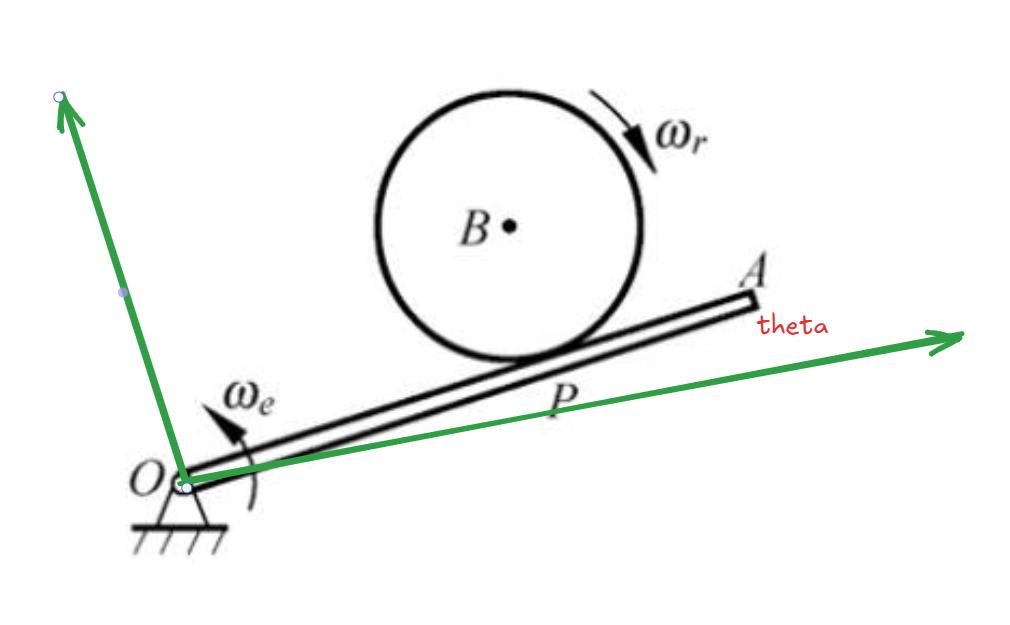

In [ ]:
reset()


def t315():
    omega_e = Symbol('omega_e')
    omega_r = Symbol('omega_r')
    omega = Symbol('omega',positive=True)
    beautiful_compute(omega_e, omega, "give:$")
    beautiful_compute(omega_r, omega * 4, "give:$")
    t = Symbol('t')
    theta = beautiful_compute('theta', omega_e * t, "init at time 0:$")
    R = Symbol('R',positive=True)
    l = beautiful_compute('l', omega_r * t*R + 3 * R, "init at time 0:$")

    tfm = Matrix([[cos(theta), -sin(theta)],
                  [sin(theta), cos(theta)]])
    pos = beautiful_compute('pos', tfm * Matrix([l, R]))
    beautiful_peek(pos,"inlined:$")
    vel = beautiful_compute('vel',diff(substitute_values(pos),t),"diff:$")
    save_as_variable(t,0)
    beautiful_peek(vel,"inlined:$")
    vel =substitute_values(vel)
    beautiful_print(sqrt(vel.dot(vel)),"length:$",tag ="answer")

t315()

# 3.16
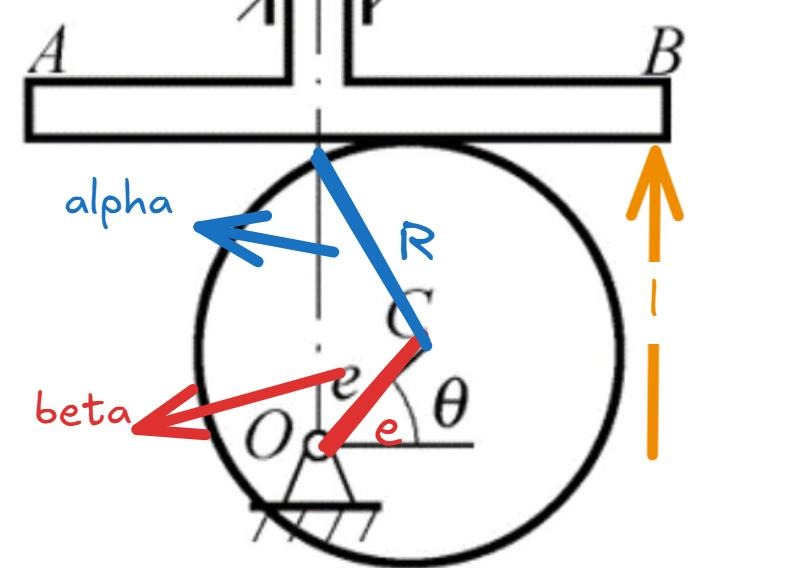

In [102]:
reset()
def t316():

t316()

by geometry:$$l{\left(t \right)} = R \cos{\left(\alpha{\left(t \right)} \right)} + e \cos{\left(\beta{\left(t \right)} \right)}$$

by geometry:$$R \sin{\left(\alpha{\left(t \right)} \right)} - e \sin{\left(\beta{\left(t \right)} \right)} = 0\tag{3}$$

diff :$$R \cos{\left(\alpha{\left(t \right)} \right)} \frac{d}{d t} \alpha{\left(t \right)} - e \cos{\left(\beta{\left(t \right)} \right)} \frac{d}{d t} \beta{\left(t \right)} = 0\tag{4}$$

$\left ( 4 \right )  \Longrightarrow$

$$\frac{d}{d t} \alpha{\left(t \right)} = \frac{e \cos{\left(\beta{\left(t \right)} \right)} \frac{d}{d t} \beta{\left(t \right)}}{R \cos{\left(\alpha{\left(t \right)} \right)}}$$

$\left ( 3 \right )  \Longrightarrow$

$$\alpha{\left(t \right)} = \pi - \operatorname{asin}{\left(\frac{e \sin{\left(\beta{\left(t \right)} \right)}}{R} \right)}$$

given:$$\frac{d}{d t} \beta{\left(t \right)} = \omega$$

because $\theta=0$:$$\beta{\left(t \right)} = \frac{\pi}{2}$$

inlined:$$\frac{d}{d t} \alpha{\left(t \right)} = 0$$

inlined:$$\alpha{\left(t \right)} = \pi - \operatorname{asin}{\left(\frac{e}{R} \right)}$$

$$\frac{d}{d t} l{\left(t \right)} = - e \omega\tag{answer}$$